In [15]:
# CAPTURE/EXTRACT STATIC FRAMES FROM VIDEO

#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import itertools as it

# print(cv2.__version__)
# vidcap = cv2.VideoCapture('solidYellowLeft-Copy1.mp4')
# success,image = vidcap.read()
# count = 0
# success = True
# while success:
#   cv2.imwrite("syl_frame%d.jpg" % count, image)     # save frame as JPEG file
#   success,image = vidcap.read()
#   print('Read a new frame: ', success)
#   count += 1

In [16]:
# CANNY EDGE DETECTION FUNCTION
def my_ced(jpg_image):

    # Read in the image and convert to grayscale
    image = mpimg.imread(jpg_image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define a kernel size for Gaussian smoothing / blurring
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

    # Define parameters for Canny and run it
    # NOTE: if you try running this code you might want to change these!
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Display the image
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(edges, cmap='Greys_r')

    print('Canny Edge Detection:' + jpg_image)
    plt.show()
    return edges


In [17]:
# MASKING AND P-HOUGH TRANSFORM TO GET LINE AND LINE-COORDINATES

class my_mpht_so(object):
    def __init__(self, m_parm, b_parm, x1_parm, y1_parm, x2_parm, y2_parm):
        self.m_parm = m_parm
        self.b_parm = b_parm
        self.x1_parm = x1_parm
        self.y1_parm = y1_parm
        self.x2_parm = x2_parm
        self.y2_parm = y2_parm


def my_mpht(jpg_image,mc_in,edges):
    
    # Read in the image
    image = mpimg.imread(jpg_image)
    
    # make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    region_select = np.copy(image)    
    
    # Define a region of interest 
    # Keep in mind the origin (x=0, y=0) is in the upper left in image processing

    # obtain these coordinates using WebPlotDigitizer at https://apps.automeris.io/wpd/
    mask_cords = mc_in

    mask_cords = np.round(mask_cords)
    mask_cords = mask_cords.astype(int)
    mask_cords = tuple(map(tuple,mask_cords))

    # Draw a line with thickness of 4 px
    ic = 1
    while (ic<len(mask_cords)):
        region_select = cv2.line(region_select,mask_cords[ic-1],mask_cords[ic],(255,0,0),4)
        ic = ic+1

    region_select = cv2.line(region_select,mask_cords[-1],mask_cords[0],(255,0,0),4)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255

    # This time we are defining a n sided polygon to mask
    imshape = image.shape
    vertices = np.array([mask_cords], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1
    theta = np.pi/180
    threshold = 2
    min_line_length = 10
    max_line_gap = 1
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on the blank
    m_parm = []
    b_parm = []
    x1_parm = []
    y1_parm = []
    x2_parm = []
    y2_parm = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
            m_parm.append((y2-y1)/(x2-x1))
            b_parm.append(y1-x1*(y2-y1)/(x2-x1))
            x1_parm.append(x1)
            y1_parm.append(y1)
            x2_parm.append(x2)
            y2_parm.append(y2)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

    # Display the image
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(region_select, cmap='Greys_r')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(combo)

    print('Masking and P-Hough Transform:' + jpg_image)
    plt.show()
    return my_mpht_so(m_parm, b_parm, x1_parm, y1_parm, x2_parm, y2_parm)
    


In [18]:
# FINAL LANE DETECTION LINES WITH TRANSPARENCY

def my_fld(jpg_image,eps_in):
    
    # DETERMINE SLOPE OF ALL THE LINES WITHIN THE MASK
    # USE SLOPE>0 AND SLOPE<0 TO SORT LEFT AND RIGHT LANES
    # ONCE SORTED DETERMINE 
    # > AVERAGE/MEAN SLOPES FOR EACH OF LEFT AND RIGHT LANES
    # > MIN Y FOR EACH OF EACH OF LEFT AND RIGHT LANES AND CORRESPONDING X
    # > using MEAN SLOPES AND and MIN Ys and CORRESPONDING Xs DETERMINE bs in y=mx+b
    # > using MEAN SLOPES AND bs AND Y=540 (X-AXIS LINE) DETERMINE CORRESPONDING X

    # Read in the image
    image = mpimg.imread(jpg_image)
    # make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    # EPS PARMS
    m_parm = eps_in.m_parm
    x1_parm = eps_in.x1_parm
    y1_parm = eps_in.y1_parm
    x2_parm = eps_in.x2_parm
    y2_parm = eps_in.y2_parm
    
    # Capture all (x,y) coordinates for the masked edge lines
    m_parm = np.asarray(m_parm)
    x1_parm = np.asarray(x1_parm)
    y1_parm = np.asarray(y1_parm)
    x2_parm = np.asarray(x2_parm)
    y2_parm = np.asarray(y2_parm)

    mp_sort = sorted(m_parm)
    x1_sort = x1_parm[np.argsort(m_parm)]
    y1_sort = y1_parm[np.argsort(m_parm)]
    x2_sort = x2_parm[np.argsort(m_parm)]
    y2_sort = y2_parm[np.argsort(m_parm)]

    mp_neg = list(filter(lambda x: x < 0, m_parm)) 
    mp_neg_len = len(mp_neg)

    mp_neg_x1 = x1_sort[0:mp_neg_len]
    mp_neg_y1 = y1_sort[0:mp_neg_len]
    mp_neg_x2 = x2_sort[0:mp_neg_len]
    mp_neg_y2 = y2_sort[0:mp_neg_len]

    mp_neg_x = np.hstack((mp_neg_x1,mp_neg_x2))
    mp_neg_y = np.hstack((mp_neg_y1,mp_neg_y2))

    min_neg_y = np.min(mp_neg_y)
    min_neg_yx = mp_neg_x[np.argmin(mp_neg_y)]

    lmn_x1y1 = (min_neg_yx,min_neg_y)

    mmp_neg = np.mean(mp_neg)
    bp_neg = min_neg_y-mmp_neg*min_neg_yx
    lmn_x2 = int(round((ysize-bp_neg)/mmp_neg))
    lmn_x2y2 = (lmn_x2,ysize)

    mp_pos = list(filter(lambda x: x > 0, m_parm))
    mp_pos_x1 = x1_sort[(mp_neg_len-1):]
    mp_pos_y1 = y1_sort[(mp_neg_len-1):]
    mp_pos_x2 = x2_sort[(mp_neg_len-1):]
    mp_pos_y2 = y2_sort[(mp_neg_len-1):]

    mp_pos_x = np.hstack((mp_pos_x1,mp_pos_x2))
    mp_pos_y = np.hstack((mp_pos_y1,mp_pos_y2))

    min_pos_y = np.min(mp_pos_y)
    min_pos_yx = mp_pos_x[np.argmin(mp_pos_y)]
    lmp_x1y1 = (min_pos_yx,min_pos_y)

    mmp_pos = np.mean(mp_pos)
    bp_pos = min_pos_y-mmp_pos*min_pos_yx
    lmp_x2 = int(round((ysize-bp_pos)/mmp_pos))
    lmp_x2y2 = (lmp_x2,ysize)

    lane_select = np.copy(image)
    # Draw a line with thickness of 4 px
    lane_select = cv2.line(lane_select,lmn_x1y1,lmn_x2y2,(255,0,0),18)
    lane_select = cv2.line(lane_select,lmp_x1y1,lmp_x2y2,(255,0,0),18)
    alpha = 0.4  # Transparency factor.
    lane_select = cv2.addWeighted(lane_select, alpha, image, 1 - alpha, 0)

    # Display the image
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(lane_select)
    
    print('Final Lane Detection and Transparency:' + jpg_image)
    plt.show()
    
#     # SAVING FINAL OUTPUT
#     fig_s = plt.figure()
#     fig_s.set_size_inches(18.5, 10.5)
#     ax_s = plt.gca()
#     ax_s.imshow(lane_select)
#     plt.axis(off)
#     plt.savefig('fo_'+jpg_image)
#     print('Final Output Saved:' + jpg_image)
    

Canny Edge Detection:syl_frame0.jpg


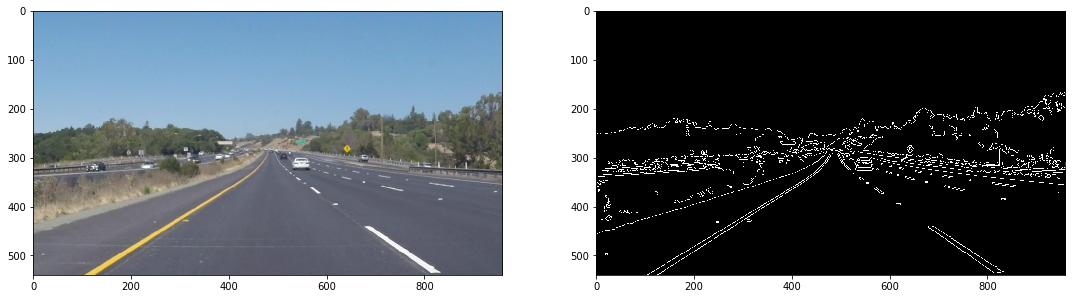

Masking and P-Hough Transform:syl_frame0.jpg


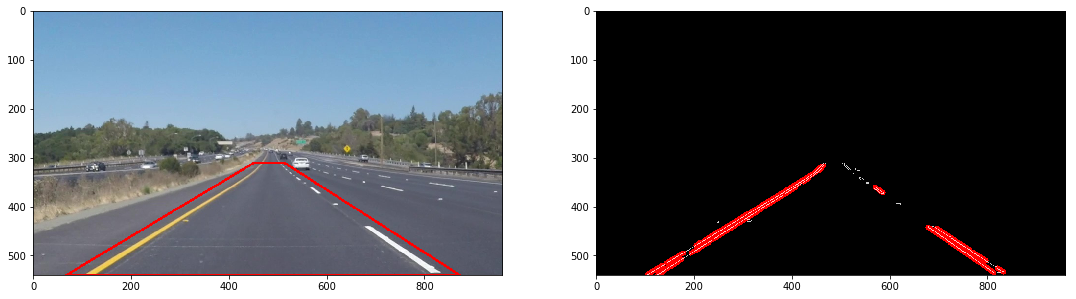

Final Lane Detection and Transparency:syl_frame0.jpg


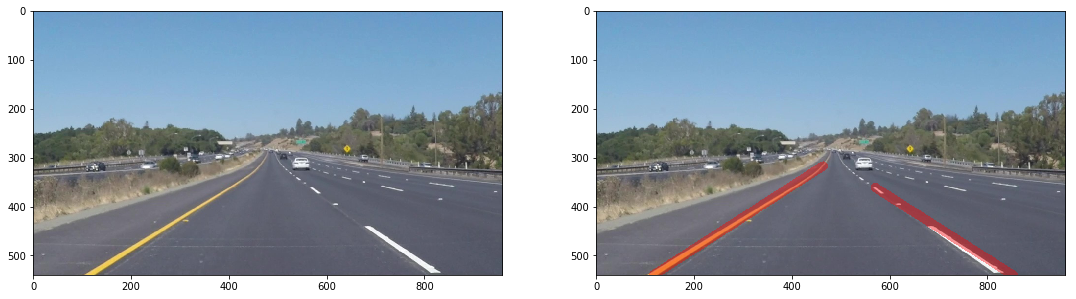

In [19]:
# PIPELINE TO EXECUTE
# > CANNY EDGE DETECTION FUNCTION
# > MASKING AND P-HOUGH TRANSFORM TO GET LINE AND LINE-COORDINATES
# > FINAL LANE DETECTION LINES WITH TRANSPARENCY
# ON EACH INDIVIDUAL STATIC FRAMES CAPTURED FROM THE VIDEO

ic = 0
# max:680
while ((ic<1)):
    
    skip_fs = [1, 11, 41, 54, 91, 157, 185, 246, 290, 302, 324, 392, 401, 493, 496, 500, 512, 513, 526, 530, 536, 555, 561, 582, 583, 585, 587, 592, 596, 597, 600, 606, 609, 613, 633, 666]
    if (ic in set(skip_fs)):
        print('skipping frame:'+str(ic)+'.jpg')
    else:
        # CURRENT STATIC FRAME/IMAGE
        jpg_image = 'syl_frame'+str(ic)+'.jpg'

        # CANNY EDGE DETECTION FUNCTION
        cur_edges = my_ced(jpg_image)

        # Define a region of interest 
        # Keep in mind the origin (x=0, y=0) is in the upper left in image processing

        if (ic <=100):
            mc_in = [(67.30158730158729, 540),
            (450.79365079365084, 310.2564102564103),
            (513.015873015873, 310.2564102564103),
            (872.3809523809525, 540)]
            
        else:
            mc_in = [(95.54563894523326, 540),
            (444.4787018255578, 320),
            (514.5314401622718, 320),
            (901.8661257606491, 540)]
        

        # MASKING AND P-HOUGH TRANSFORM TO GET LINE AND LINE-COORDINATES    
        my_mpht_out = my_mpht(jpg_image,mc_in,cur_edges)
        
        # FINAL LANE DETECTION LINES WITH TRANSPARENCY
        my_fld(jpg_image,my_mpht_out)

    ic = ic+1
    

In [20]:
# MAKING VIDEO FROM FINAL OUTPUT FRAMES

fo_syl_frame0 = cv2.imread('fo_syl_frame0.jpg')

vid_height, vid_width, vid_layers =  fo_syl_frame0.shape

fourcc = cv2.VideoWriter_fourcc(*'X264')
vid_out = cv2.VideoWriter('solidYellowLeft_fo.mp4',fourcc,25,(vid_width,vid_height),True)

ic2 = 0
# max:680

while ((ic2<681)):
    
    skip_fs = [1, 11, 41, 54, 91, 157, 185, 246, 290, 302, 324, 392, 401, 493, 496, 500, 512, 513, 526, 530, 536, 555, 561, 582, 583, 585, 587, 592, 596, 597, 600, 606, 609, 613, 633, 666, 679, 680]
    if (ic2 in set(skip_fs)):
        print('skipping frame:'+str(ic2)+'.jpg')
    else:
        print(ic2)
        cur_img = cv2.imread('fo_syl_frame'+str(ic2)+'.jpg')
        vid_out.write(cur_img)
        
    ic2 = ic2+1

# cv2.destroyAllWindows()
vid_out.release()        
        
        

0
skipping frame:1.jpg
2
3
4
5
6
7
8
9
10
skipping frame:11.jpg
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
skipping frame:41.jpg
42
43
44
45
46
47
48
49
50
51
52
53
skipping frame:54.jpg
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
skipping frame:91.jpg
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
skipping frame:157.jpg
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
skipping frame:185.jpg
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
2